### Preparations

In [0]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import clear_output
import matplotlib.image as mpimg

import keras 
from __future__ import print_function
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import PReLU

!pip install emnist

#from emnist import extract_training_samples
#from emnist import extract_test_samples
clear_output()

In [0]:
!wget "https://drive.google.com/uc?export=view&id=1vF8JiWOEkNd5NxtvQ1wfr8D-U3YGH3kf" -O russian_plate_recog.jpg
img = cv2.imread('russian_plate_recog.jpg')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#plt.imshow(img_gray, cmap = 'gray')
clear_output()

In [0]:
plate_points_1 = np.float32([[1028, 874], [1184, 890], [1027, 906], [1184, 924]]) #KIA 0)Upper Left 1)Upper Right 2)Bot Rihgt
plate_points_2 = np.float32([[293, 714], [422, 719], [291, 743], [421, 749]])

## Step 1 -> Undistort

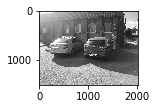

In [0]:
img_to_draw = np.copy(img_gray)
#KIA
# image, line begin point, line end point, color, thikness
cv2.line(img_to_draw, (plate_points_1[0][0],plate_points_1[0][1]), (plate_points_1[1][0],plate_points_1[1][1]), (255,255,0), 4)
cv2.line(img_to_draw, (plate_points_1[1][0],plate_points_1[1][1]), (plate_points_1[3][0],plate_points_1[3][1]), (255,255,0), 4)
cv2.line(img_to_draw, (plate_points_1[2][0],plate_points_1[2][1]), (plate_points_1[3][0],plate_points_1[3][1]), (255,255,0), 4)
cv2.line(img_to_draw, (plate_points_1[2][0],plate_points_1[2][1]), (plate_points_1[0][0],plate_points_1[0][1]), (255,255,0), 4)
plt.subplot(232)
#Shkoda
cv2.line(img_to_draw, (plate_points_2[0][0],plate_points_2[0][1]), (plate_points_2[1][0],plate_points_2[1][1]), (255,0,255), 4)
cv2.line(img_to_draw, (plate_points_2[1][0],plate_points_2[1][1]), (plate_points_2[3][0],plate_points_2[3][1]), (255,0,255), 4)
cv2.line(img_to_draw, (plate_points_2[2][0],plate_points_2[2][1]), (plate_points_2[3][0],plate_points_2[3][1]), (255,0,255), 4)
cv2.line(img_to_draw, (plate_points_2[2][0],plate_points_2[2][1]), (plate_points_2[0][0],plate_points_2[0][1]), (255,0,255), 4)
plt.imshow(img_to_draw, cmap = 'gray')
plt.show()

I want to get picture of the plate with shape (220, 50). This 2 functions will help me:
- cv2.getPerspectiveTransform
- cv2.warpPerspective

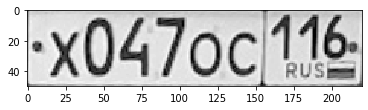

In [0]:
new_img_KIA = np.float32([[0, 0], [220, 0], [0, 50], [220, 50]])

matrix = cv2.getPerspectiveTransform(plate_points_1, new_img_KIA)

result = cv2.warpPerspective(img_gray, matrix, (220, 50))

plt.imshow(result, cmap = 'gray')
plt.show()

I want to get a binary image. I will use this functions:
- cv2.threshold
- cv2.findContours

Number of contours: 22


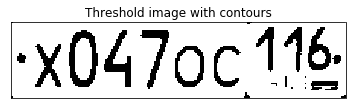

(50, 220)


In [0]:
# findContours and minAreaRect may help you
result_gray = result

ret, thresh = cv2.threshold(result_gray, 93, 255, cv2.THRESH_BINARY)

contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
im2 = cv2.drawContours(thresh, contours, -1, (255, 0, 0), 1)
img_contours = result.copy()

print('Number of contours: {}'.format(len(contours)))

# draw contours on input image
#cv2.drawContours(img_contours, contours, -1, (255,0,0), 1)

plt.imshow(im2,cmap = 'gray')
plt.title('Threshold image with contours'), plt.xticks([]), plt.yticks([])
plt.show()

I go 22 contours, but i need only 9. I know x, y, w, h parameters of each contour. So I will put threshold and drow only 9 contours.

(<matplotlib.image.AxesImage at 0x7f2caebdd668>,
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

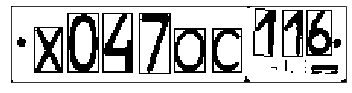

In [0]:
img_rectangle_rot = im2.copy()
for i in range (0, len(contours)):
  x, y, w, h = cv2.boundingRect(contours[i])
  if w >= 13 and w < 200 and h >= 29:
    contour = contours[i]
    rect = cv2.minAreaRect(contour) 
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.drawContours(img_rectangle_rot,[box], 0, (0,0,255), 1)

plt.imshow(img_rectangle_rot, cmap = 'gray'), plt.xticks([]), plt.yticks([])

Here I sort 9 contours

In [0]:
xx = []
listik = []
img_rectangle = im2.copy()
for i in range (0, len(contours)):
  x, y, w, h = cv2.boundingRect(contours[i])
  if w >= 13 and w < 200 and h >= 29:
    xx.append(x)
    im = img_rectangle[y-3:y+h+4, x-5:x+w+3]
    im = cv2.resize(im, (28,28))
    listik.append(im)
# Sort
for i in range(len(listik) - 1):
  for j in range(len(listik) - i - 1):
    if xx[j] > xx[j+1]:
      xx[j], xx[j+1] = xx[j+1], xx[j]
      listik[j], listik[j+1] = listik[j+1], listik[j]

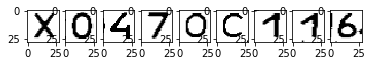

In [0]:
def showInRow(list_of_images, titles = None, disable_ticks = False):
  count = len(list_of_images)
  for idx in range(count):
    subplot = plt.subplot(1, count, idx+1)
    if titles is not None:
      subplot.set_title(titles[idx])
      
    img = list_of_images[idx]
    cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
    subplot.imshow(img, cmap=cmap)
    if disable_ticks:
      plt.xticks([]), plt.yticks([])

showInRow([listik[0], listik[1], listik[2], listik[3], listik[4], listik[5], listik[6], listik[7], listik[8]])

In [0]:
listik_filt = np.copy(listik)

Add noise to images

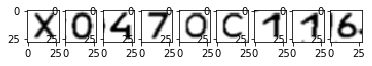

In [0]:
for i in range(len(listik_filt)): 
  listik_filt[i] = cv2.GaussianBlur(listik_filt[i], (3,3), 0)

showInRow([listik_filt[0], listik_filt[1], listik_filt[2], listik_filt[3], listik_filt[4], listik_filt[5], listik_filt[6], listik_filt[7], listik_filt[8]])

## Step 3 -> Recognition

####This model is training on EMNIST

In [0]:
batch_size = 128
num_classes = 62
epochs = 12

img_rows, img_cols = 28, 28

x_train, y_train = extract_training_samples("byclass")
x_test, y_test = extract_test_samples("byclass")

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy:', score[1])
#clear_output()

x_train shape: (697932, 28, 28, 1)
697932 train samples
116323 test samples
Train on 697932 samples, validate on 116323 samples
Epoch 1/12
697932/697932 [==============================] - 122s 174us/step - loss: 0.7089 - acc: 0.7815 - val_loss: 0.4327 - val_acc: 0.8481
Epoch 2/12
697932/697932 [==============================] - 120s 172us/step - loss: 0.5092 - acc: 0.8303 - val_loss: 0.4104 - val_acc: 0.8530
Epoch 3/12
697932/697932 [==============================] - 121s 173us/step - loss: 0.4803 - acc: 0.8387 - val_loss: 0.4024 - val_acc: 0.8552
Epoch 4/12
697932/697932 [==============================] - 121s 174us/step - loss: 0.4649 - acc: 0.8428 - val_loss: 0.3902 - val_acc: 0.8588
Epoch 5/12
697932/697932 [==============================] - 122s 175us/step - loss: 0.4551 - acc: 0.8459 - val_loss: 0.3954 - val_acc: 0.8607
Epoch 6/12
697932/697932 [==============================] - 120s 172us/step - loss: 0.4476 - acc: 0.8475 - val_loss: 0.3855 - val_acc: 0.8620
Epoch 7/12
697932/69

In [0]:
simbols = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 
           'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 
           'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 
           'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

####Recognition Numbers and Letters

In [0]:
answers = []
for i in range(0, len(listik_filt)):
  listik_filt[i] = 255 - listik_filt[i]
  newIm = cv2.resize(listik_filt[i], (28, 28))
  newIm = newIm.astype('float32')/255
  pr = model.predict(newIm.reshape(1,28,28,1))
  pred = np.argmax(pr)
  answers.append(simbols[pred])
print("predicted", answers)
print('true        x,   0,   4,   7,   o,   c,   1,   1,   6')

predicted , x,   0,   4,   7,   o,   c,   1,   1,   6
true        x,   0,   4,   7,   o,   c,   1,   1,   6


The same process the the 2nd Pic

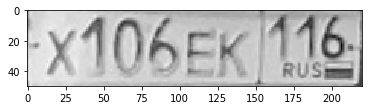

In [0]:
# findHomography and warpPerspective may help you
new_img_SHKODA = np.float32([[0, 0], [220, 0], [0, 50], [220, 50]])

matrix = cv2.getPerspectiveTransform(plate_points_2, new_img_SHKODA)

result_SHKODA = cv2.warpPerspective(img_gray, matrix, (220, 50))

plt.imshow(result_SHKODA, cmap = 'gray')
plt.show()

Number of contours: 35


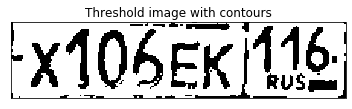

In [0]:
block_size = 55 
c_value = 6 
result_gray_SHKODA = result_SHKODA 

kernel = np.ones((4,1), np.uint8) 

thresh = cv2.adaptiveThreshold(result_gray_SHKODA,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,block_size,c_value)

contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
im3 = cv2.drawContours(thresh, contours, -1, (255, 0, 0), 1)
img_contours = result_SHKODA.copy()

print('Number of contours: {}'.format(len(contours)))

plt.imshow(im3,cmap = 'gray')
plt.title('Threshold image with contours'), plt.xticks([]), plt.yticks([])
plt.show()

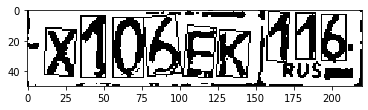

In [0]:
img_rectangle_rot_SHKODA = im3.copy()
for i in range (0, len(contours)):
  x, y, w, h = cv2.boundingRect(contours[i])
  if w >= 13 and w < 200 and h >= 29:
    contour = contours[i]
    rect = cv2.minAreaRect(contour) 
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.drawContours(img_rectangle_rot_SHKODA,[box], 0, (0,0,255), 1)

plt.imshow(img_rectangle_rot_SHKODA, cmap = 'gray')#№, plt.xticks([]), plt.yticks([])

In [0]:
ss = []
listik_SHKODA = []
img_rectangle_SHKODA = im3.copy()
for i in range (0, len(contours)):
  x, y, w, h = cv2.boundingRect(contours[i])
  if w >= 13 and w < 200 and h >= 29:
    ss.append(x)
    im = img_rectangle_SHKODA[y:y+h, x:x+w]
    im = cv2.resize(im, (28,28))
    listik_SHKODA.append(im)
# Sort
for i in range(len(listik_SHKODA) - 1):
  for j in range(len(listik_SHKODA) - i - 1):
    if ss[j] > ss[j+1]:
      ss[j], ss[j+1] = ss[j+1], ss[j]
      listik_SHKODA[j], listik_SHKODA[j+1] = listik_SHKODA[j+1], listik_SHKODA[j]

9


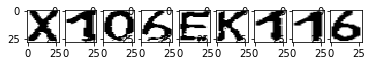

In [0]:
def showInRow(list_of_images, titles = None, disable_ticks = False):
  count = len(list_of_images)
  for idx in range(count):
    subplot = plt.subplot(1, count, idx+1)
    if titles is not None:
      subplot.set_title(titles[idx])
      
    img = list_of_images[idx]
    cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
    subplot.imshow(img, cmap=cmap)
    if disable_ticks:
      plt.xticks([]), plt.yticks([])
print(len(listik_SHKODA))
showInRow([listik_SHKODA[0], listik_SHKODA[1], listik_SHKODA[2], listik_SHKODA[3], listik_SHKODA[4], listik_SHKODA[5], listik_SHKODA[6], listik_SHKODA[7], listik_SHKODA[8]])

In [0]:
listik_filt_SHKODA = np.copy(listik_SHKODA)

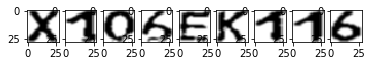

In [0]:
for i in range(len(listik_filt_SHKODA)):
  listik_filt_SHKODA[i] = cv2.GaussianBlur(listik_filt_SHKODA[i], (3,3), 0)

showInRow([listik_filt_SHKODA[0], listik_filt_SHKODA[1], listik_filt_SHKODA[2], listik_filt_SHKODA[3], listik_filt_SHKODA[4], listik_filt_SHKODA[5], listik_filt_SHKODA[6], listik_filt_SHKODA[7], listik_filt_SHKODA[8]])

####Recognition Numbers and Letters

In [0]:
answers2 = []
for i in range(0, len(listik_filt_SHKODA)):
  listik_filt_SHKODA[i] = 255 - listik_filt_SHKODA[i]
  newIm = cv2.resize(listik_filt_SHKODA[i], (28, 28))
  newIm = newIm.astype('float32')/255
  pr = model.predict(newIm.reshape(1,28,28,1))
  pred = np.argmax(pr)
  answers2.append(simbols[pred])
print("predicted", answers2)
print('true        x,   1,   0,   6,   e,   k,   1,   1,   6')

predicted , x,   1,   0,   6,   e,   k,   1,   1,   6'
true        x,   1,   0,   6,   e,   k,   1,   1,   6
